# Tutorial on Recurent Neural Networks

Author: *Oleksiy Ostapenko*

(Used sources: [Deep Learning Book](https://www.deeplearningbook.org/), [Christophe Olah's Blog](http://colah.github.io/), RNNs [tutorial](https://colab.research.google.com/drive/1jR_DGoVDcxZ104onxTk2C7YeV7vTt1DV#scrollTo=dRNYHWwYyd4Q) by Yen-Ling Kuo and Eugenio Piasini)

In this tutorial session, we will explore how to model sequential data using recurrent neural networks (RNNs). In the first part, we will build an intuition on some moving parts of RNNs on a toy problem. The second part of the tutorial will showcase an example of applying RNNs to a more realistic dataset of textual data.

Here we will use [Pytorch](https://colab.research.google.com/drive/1y9raF4S_HM3XU8e6es5j_l0WerKTQJeu#scrollTo=9OpW6mo6Nwgy&line=1&uniqifier=1) library, which is a popular open-source library that provides many convenient tools for building artificial neural networks. 

# Part 1: simple example (learning a sine wave)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import numpy as np
torch.manual_seed(2024)
np.random.seed(2024)

%matplotlib inline
import matplotlib.pyplot as plt

Let's first generating some data!

In [ ]:
def generate_sinus_wave(train_len, valid_len):
    time_steps = np.linspace(0, 8*np.pi, train_len+valid_len)
    data = np.sin(time_steps)

    xs = data[:train_len-1]
    ys = data[1:train_len] # as discussed in class, targets are shifted by 1 step

    train_x = torch.Tensor(xs).view(-1, 1, 1)
    train_y = torch.Tensor(ys)
    return data, time_steps, train_x, train_y

In [ ]:
seq_length = 200 #total sequence length
portion_train =0.1 #portion of the sequence length used for training

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len
data, time_steps, train_x, train_y = generate_sinus_wave(train_len = train_len, valid_len = valid_len)

#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

We formulate the task as predicting the point at time step $t+1$ given the sequence of previous inputs up untill time step $t$. We, therefore, need to shift our targets by one as mentioned in the class. Let's have a closer look at our input and target data again **(note: targets are shifted by 1)**.

In [ ]:
#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], train_x, s=90, c='g', label='train')
plt.scatter(time_steps[1:train_len], train_y, s=20, c='r', label='targets')
ax.legend()

We will use data generated from a sine curve for our toy sequential prediction problem. Namely, given some part of the sequence as training data (blue points in the visualization above), our model will be tasked to generate the rest of the sequence (orange points).

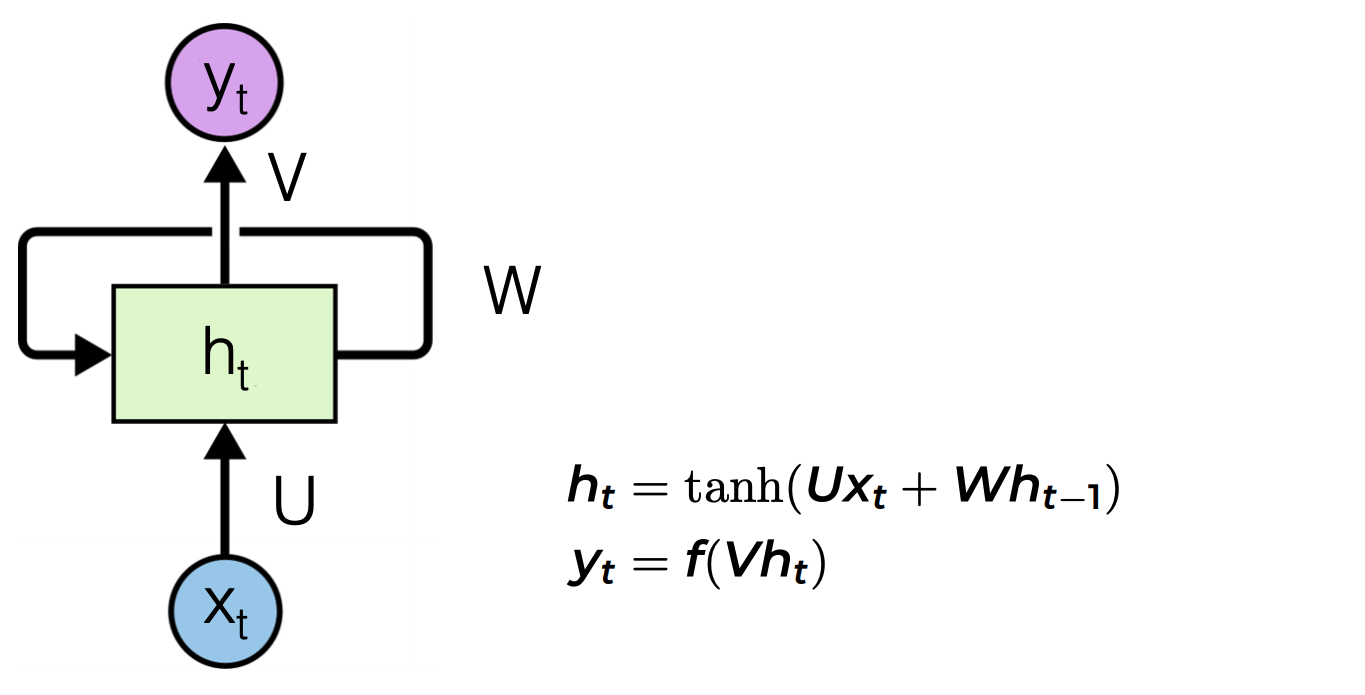
Image source http://colah.github.io/

As we have seen in the class, a simple recurrent network cell takes the current input at $X_t$ and produces an output ($y_t$) and a new hidden state that is passed through a recurrent connection to the next time step (in the figure above the recurrent connection uses weights W).

Let's first implement this simple RNN cell using Pytorch. Note, we will replace the $tanh$ activation with $sigmoid$ (covered in the previous tutorial), as it produced better empirical results for the sine wave task (yes, Deep Learning is a very empirical field).

As you might recall from the previous lecture on feed-forward neural networks, the second equation in the figure above ($y_t = f(Vh_t)$) looks very similar to the feedforward layer. Indeed it is one, where $V$ denotes our learnable weights and $f$ is our activation function. Pytorch already provides us with an implementation of such a layer. We will add it outside of our simple RNN cell for convenience.


In [ ]:
class RNN_Cell(nn.Module): 
    def __init__(self, input_size, hidden_size):
        super(RNN_Cell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size)) #we will randomly innitialize out trainable parameters
        self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))

        self.b = torch.nn.Parameter(torch.randn(hidden_size))

    def forward(self, x_t, state):

        h_prev = state

        #here, we simply write down the equations from the figure above in the pytorch 'language'
        a = torch.mm(x_t, self.U) + torch.mm(h_prev, self.W) + self.b
        h = torch.sigmoid(a)

        return h

Now, having implemented our simple recurrent cell, we need to put cells together to form a network. 

Remember the principle of RNNs? The same(!) cell is used repeatedly receiving the new $X_t$ and the previous hidden state as input.

 We will also add our missing feed-forward layer (equation $y_t = f(Vh_t)$) here (we will set $f$ to identity, since we dont need any additional activation function here).

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn_cell = RNN_Cell(input_dim, hidden_size)
        self.linear = nn.Linear(hidden_size, 1) # here is out missing equation from before, in Torch the feed-forward layers are called Linear

    def init_hidden(self,):
        return torch.zeros(1,self.hidden_size) #we will initialize our hidden state with zeros
    
    def forward(self, X, h=None):
        self.h = self.init_hidden() if h is None else h
        outputs = []

        # we will process the sequence here
        for X_t in X:

            self.h = self.rnn_cell.forward(X_t, self.h)

            y_t = self.linear.forward(self.h)
            outputs.append(y_t)

        return torch.stack(outputs), self.h

**Question 1 (RNNs)** : in the standard feed-forward neural network, all the training and test samples are considered independently. Can you explain how this can be a bad fit for sequential data modeling like stock market prediction or sequential sine curve fitting?

In which line of code in the $forward$ function in the previous cell do we explicitly break the assumption of data samples in the sequence being independent from each other?


**Question 2 (RNNs)**: given your answers to the previous question, can you explain in your own words, which role the hidden state ($h$) plays in RNNs?







Okay, we have implemented the 'forward path' of our RNN model. But what about the actual learning. The learning algorithm that is usually used to train RNNs is called [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time). Don't be afraid of the fancy name though, the essential idea that underlines this and many other learning algorithms for the deep neural network is just repeatedly applying the chain rule of differentiation: 

if $F = f(y), y = g(x)$, we have that $ \frac{dF}{dx} = \frac{dF}{dy} \frac{dy}{dx}  $ (given f and g are differential functions).

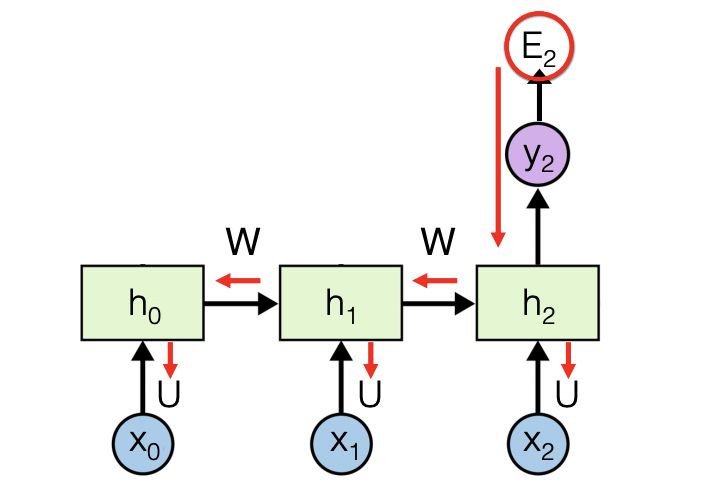
Image source http://colah.github.io/

The above image depicts a simple RNN with 3 states. Let's put it into mathematical equations ignoring the activation functions (and assuming our learnable weights are just scalars).

$h_o = U x_0$

$h_1 = U x_1 + W h_0$ 

$h_2 = U x_2 + W h_1$ 

Suppose we are dealing with a regression problem, let's include a simple L2 loss:

$E = \frac{1}{2} (h_2 - y)^2 $, where $y$ is the ground truth.

**Question 3 RNNs (Bonus)** : write down equations for the backpropagation through time for states $h_0$, $h_1$ and $h_2$ (hint: simply use chain-rule starting from the error term).




Don't worry, we are not going to and code the backpropagation equations by hand, Pytorch will do the tedious work of differentiation for us. 

Finally, let's now train our simple RNN on the input sequence generated previously.

In [ ]:
hidden_size = 10
learning_rate = 0.01


In [ ]:
model = RNN(1,hidden_size) # first we instantiate our model

criterion = nn.MSELoss() # we are using means squered error as loss function here
# this will set-up an optimizer for parameter updates, feel free to ignore this for now!
optimizer = optim.Adam(model.parameters(), learning_rate) 

epochs = 300 # one epoch corresponds to a single pass through the entire training data
for epoch in range(epochs):
    optimizer.zero_grad()
    
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Let's see how our trained model can predict the training labels. Given a point from our training data (time $t$), we will ask our model to generate the next point ($t+1$), one point at a time. We will carry over the hidden state along the sequence generation.

In [ ]:
def make_predictions_train(model):
    predictions = []
    hidden_prev = None
    # we will go over all points in out training sequence
    for i in range(train_x.shape[0]):
        input = train_x[i]
        input = input.view(1, 1, 1)
      
        #we will give the current (single) point and the (current) hidden state as input to our model
        pred, hidden_prev = model(input, hidden_prev) # <- we cary over the previous hidden state
        predictions.append(pred.data.numpy()[0][0])
    return predictions, hidden_prev

predictions_train, hidden_prev = make_predictions_train(model)

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], data[:train_len-1], s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions_train, label='predicted')
ax.legend()

As we can see in the plot above, that our model has learned to fit the training part of the sequence almost perfectly.

But what about the unseen part of the sequence? 

In [ ]:
def generate_unseen_sequence(model, length, starting_point, hidden_state):
    predicts=[]
    input = torch.Tensor(starting_point).view(1,1,1)
    for i in range(length):
        pred, hidden_state = model(input, hidden_state)
        predicts.append(pred.data.numpy()[0][0])
        input = pred
    return predicts


Let's generate the part of the sequence which was hidden from the model at training. Note, from the model's perspective, it is like generating completely new unseen data. If our data was e.g. text instead of a simple sine wave, we could ask our model to generate a completely new text, isn't that cool?

Note, to generate unsee part of the sequence:
- we will first condition on the last point from the seen sequence, and ask the model to generate a new point
- then we will pass this newly generated point and the new hidden state as input to out model
- thde model wil then generate a new point conditioned on a point previously generated by the model
- in theory we could generate an infinitely long sequence on new data in this way.

In [ ]:
generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)

predictions = predictions_train+generated_points #concatenate two lists

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

As can be seen in the plot above, our model's performance is quite poor when it comes to generating the unseen part of the sequence (shown in green). 

Looking at our training sequence (the orange part in the plot above), does it actually contain the information needed to be able to capture the periodic nature of the siune wave? Well, even as a human, if you had never seen a sine wave before, you probably would not be able to learn what a sine wave is solely from observing half of the period length of a sine wave (you would probably think it's just a parabola).

**Question 4 (RNNs)**: try increasing the training sequence length ($portion\_train$) in the code snippet below. (hint: set the training length such that it includes at least one complete cycle of the sine wave)

In [ ]:

portion_train = 0.1 # change this parameter to try out a longer training sequence to cover at least one period

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len

data, time_steps, train_x, train_y = generate_sinus_wave(train_len = train_len, valid_len = valid_len)

fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

Let's train our model again and see the result.

In [ ]:
model = RNN(1,hidden_size)
optimizer = optim.Adam(model.parameters(), learning_rate)
epochs = 500 #
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

In [ ]:
#get training data predictions
predictions_train, hidden_prev = make_predictions_train(model)
#generate unsee points
generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)
#concatenate two lists
predictions = predictions_train+generated_points 
#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

And voilà, our new model is somewhat better in capturing the periodic nature of the sine wave. 

Note, if you re-run the training procedure for several times you will observe that each time you get a different result. This is due to the random reinnitialization of the trainable weight in our RNN cell each time you restart training (re-instantiate the network object):

```
self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size)) 

self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
```


We certainly could try to get some better results by either:
- further hyperparameter tuning
- further increasing the length of the training sequence (MORE DATA is always good)

These are valid strategies often used in deep learning to improve the performance of the models. Yet, many times the real innovations comes from improving the actual learning algorithms. 

So let's try to replace our simple RNN cell with a different cell - an LSTM cell. As mentioned in class, LSTM cells are better in 'remembering' long term dependencies in the data. Please, refer to this [blog article](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) to see how LSTMS are different from the standard RNNs.

In [ ]:
class RNN_wLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNN_wLSTM, self).__init__()

        self.hidden_size = hidden_size

        ### NEW CELL ###  
        #we will use the pytorch implementation of the LSTM cell
        self.rnn_cell = nn.LSTMCell(1, hidden_size)
        ################

        self.linear = nn.Linear(hidden_size, 1) # here is out missing equation from before, in Torch the feed-forward layers are called Linear

    def init_hidden(self,):
        return (torch.zeros( 1, self.hidden_size),  torch.zeros( 1, self.hidden_size))
    
    def forward(self, X, h=None):
        self.h = self.init_hidden() if h is None else h
        outputs = []

        # we will process the sequence here
        for X_t in X:
            self.h = self.rnn_cell(X_t, self.h)

            y_t = self.linear.forward(self.h[0])
            outputs.append(y_t)

        return torch.stack(outputs), self.h

In [ ]:
model = RNN_wLSTM(1, hidden_size)
optimizer = optim.Adam(model.parameters(), 0.1)
epochs = 300
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

In [ ]:
#get training data predictions
predictions_train, hidden_prev = make_predictions_train(model)
#generate unsee points
generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)
#concatenate two lists
predictions = predictions_train+generated_points 
#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

As can be seen in the plot above, LSTMs can better capture the period length and the amplitude of our wave and are more robust (converge consistently to a similarly good result if you re-run the training for everal times).

# Part 2: language modeling



Let's have a look on mode complex task of language generation now. We will build an RNN that will generate text one character at a time (this part largely relies on the tutorial put together by Yen-Ling Kuo and Eugenio Piasini that can be found [here](https://colab.research.google.com/drive/1jR_DGoVDcxZ104onxTk2C7YeV7vTt1DV#scrollTo=dRNYHWwYyd4Q)). First, let's download some training data, which consists of Shakespear's texts.

In [ ]:
input_file = 'input.txt'
!if [ ! -f $input_file ]; then wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt; fi

We will write a function that will generate random chunks of text as input sequences to our RNN.

In [ ]:

!pip3 install unidecode

import random
import unidecode

file = unidecode.unidecode(open('input.txt').read())

def random_chunk(chunk_len=200):
    start_index = random.randint(0, len(file) - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]
  

Let's have a look on some random input sequence.

In [ ]:
print(random_chunk())

We will convert words to integer indexes such that each character has a unique id.

We also provide a function to produce a random training sequence. The input is the character at time $t$. The target is the expected character to see at $t+1$.

In [ ]:
import string

# Turn string into list of longs
def char_tensor(str, print_=False):
    tensor = torch.zeros(len(str), 1).long()
    for c in range(len(str)):
        tensor[c][0] = string.printable.index(str[c])
        if print_:
          print(f"Character: {str[c]} gets index {tensor[c][0]}")
    return tensor

char_tensor('Hello, how are you?', print_=True)

def random_train_data():    
    chunk = random_chunk()
    input = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return input, target

Now, we will set up the model.

This model will take as input the character for time step $t$ and is expected to output the character at $t+1$. There are three layers - one embedding layer that encodes the input character into a dense vector, one recurent layer that operates on that dense vector and a hidden state, and a decoder layer that outputs the probability distribution over all possible characters.

Note, we will use a [GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit) cell here, which is another variation of recurent cell similar to LSTM.


In [ ]:
class ShakespeareRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(ShakespeareRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.embeding_size = 6
        
        self.embedding = nn.Embedding(len(string.printable), self.embeding_size) 
        self.rnn = nn.GRU(self.embeding_size, hidden_size, num_layers=n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def init_hidden(self):
         return torch.zeros(self.n_layers, 1, self.hidden_size)
    
    def forward(self, input, hidden):
        x = self.embedding(input)
        x, hidden = self.rnn(x.view(1,1,x.size(-1)), hidden)
        output = self.decoder(x)
        tag_scores = F.log_softmax(output[-1], dim=1)
        return output, hidden

In [ ]:
def evaluate(model, prime_str='A', predict_len=100):
    hidden = model.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    input = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(input, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = string.printable[top_i]
        predicted += predicted_char
        input = char_tensor(predicted_char)

    return predicted

It's time to train our model!

In [ ]:
n_characters = len(string.printable)
hidden_size = 100
n_layers = 2

epochs = 2000
lr = 0.005

model = ShakespeareRNN(n_characters, hidden_size, n_characters, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    loss = 0
    input, target = random_train_data()
    chunk_len = len(input)
    hidden = model.init_hidden()

    model.zero_grad()
    for x,y in zip(input, target):
      out, hidden = model(x, hidden)
      loss += criterion(out[-1], y)
    
    loss.backward()
    optimizer.step()

    loss = loss.item() / chunk_len
    if epoch % 100 == 0:
        print('[(%d %d%%) %.4f]' % (epoch, epoch / epochs * 100, loss))
        print(evaluate(model, 'Wh', 100), '\n')

Let's use out model to generate some text conditionaning on different starting sequences:

In [ ]:
print(evaluate(model, 'Wh', predict_len=100), '\n')

In [ ]:
print(evaluate(model, 'How', predict_len=100), '\n')

In [ ]:
print(evaluate(model, 'JULIET', predict_len=100), '\n')